# Gradient descent in linear matrix learning

This notebook reproduces the subpanels of Fig 4.


## Import and helper functions

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim

from sklearn import decomposition
import seaborn as sns

from tqdm import tqdm

In [15]:

# define stimulus parameters
# stim_dur = 5.0  # stimulus duration in seconds
# fps = 60  # frames per second
# win_size = [800, 600]  # size of the window
# grating_size = [400, 400]  # size of the grating
# sf = 0.05  # spatial frequency of the grating
# tf = 2.0  # temporal frequency of the grating
# angle = 45.0  # orientation angle of the grating



def get_moving_gratings(stim_dur, fps, image_shape, sf, tf, angle):
    win_size= image_shape
    grating_size = image_shape
    # create a meshgrid of x and y coordinates
    x, y = np.meshgrid(np.arange(grating_size[0]), np.arange(grating_size[1]))

    # create a sequence of image matrices
    stim_frames = []
    for i in range(int(stim_dur * fps)):
        # calculate the phase of the grating
        phase = (i / fps * tf * 2.0 * np.pi) % (2.0 * np.pi)

        # calculate the grating pattern
        grating = np.sin(2.0 * np.pi * (sf * (np.cos(angle * np.pi / 180.0) * x + np.sin(angle * np.pi / 180.0) * y) - phase))

        # create a black image and paste the grating onto it
        img = np.zeros((win_size[1], win_size[0]))
        img[(win_size[1] - grating_size[1]) // 2:(win_size[1] + grating_size[1]) // 2,
            (win_size[0] - grating_size[0]) // 2:(win_size[0] + grating_size[0]) // 2] = grating

        # append the image matrix to the stimulus frames
        stim_frames.append(img)
    return stim_frames


In [43]:
np.linspace(0,180,3,endpoint=False)

array([  0.,  60., 120.])

In [48]:
stim_dur = 1.0  # stimulus duration in seconds
fps = 10  # frames per second
# win_size = [800, 600]  # size of the window
image_shape = [224, 224]  # size of the grating
sf = 0.005  # spatial frequency of the grating
tf = 0.5  # temporal frequency of the grating
angle = 45.0  # orientation angle of the grating

stim_seqs = []
for sf in np.logspace(-4,-1,4):#7):
    for angle in np.linspace(0,180,3, endpoint=False):#10):
        for tf in np.logspace(-2,-0.5,3):#(-2,0,3):#5):
            stim_seqs.append(
                get_moving_gratings(stim_dur, fps, image_shape, sf, tf, angle))
# plot the first frame of the stimulus
# plt.subplots(1,2,figsize=(4,))
# plt.imshow(stim_frames[0], cmap='gray')
# plt.axis('off')
# plt.show()


In [53]:
10**(-0.5)

0.31622776601683794

In [49]:
stim_seqs = np.asarray(stim_seqs)
stim_seqs.shape

(36, 10, 224, 224)

(<Figure size 1440x5184 with 360 Axes>,
 array([[<AxesSubplot:title={'center':'t=0'}>,
         <AxesSubplot:title={'center':'t=1'}>,
         <AxesSubplot:title={'center':'t=2'}>,
         <AxesSubplot:title={'center':'t=3'}>,
         <AxesSubplot:title={'center':'t=4'}>,
         <AxesSubplot:title={'center':'t=5'}>,
         <AxesSubplot:title={'center':'t=6'}>,
         <AxesSubplot:title={'center':'t=7'}>,
         <AxesSubplot:title={'center':'t=8'}>,
         <AxesSubplot:title={'center':'t=9'}>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>,

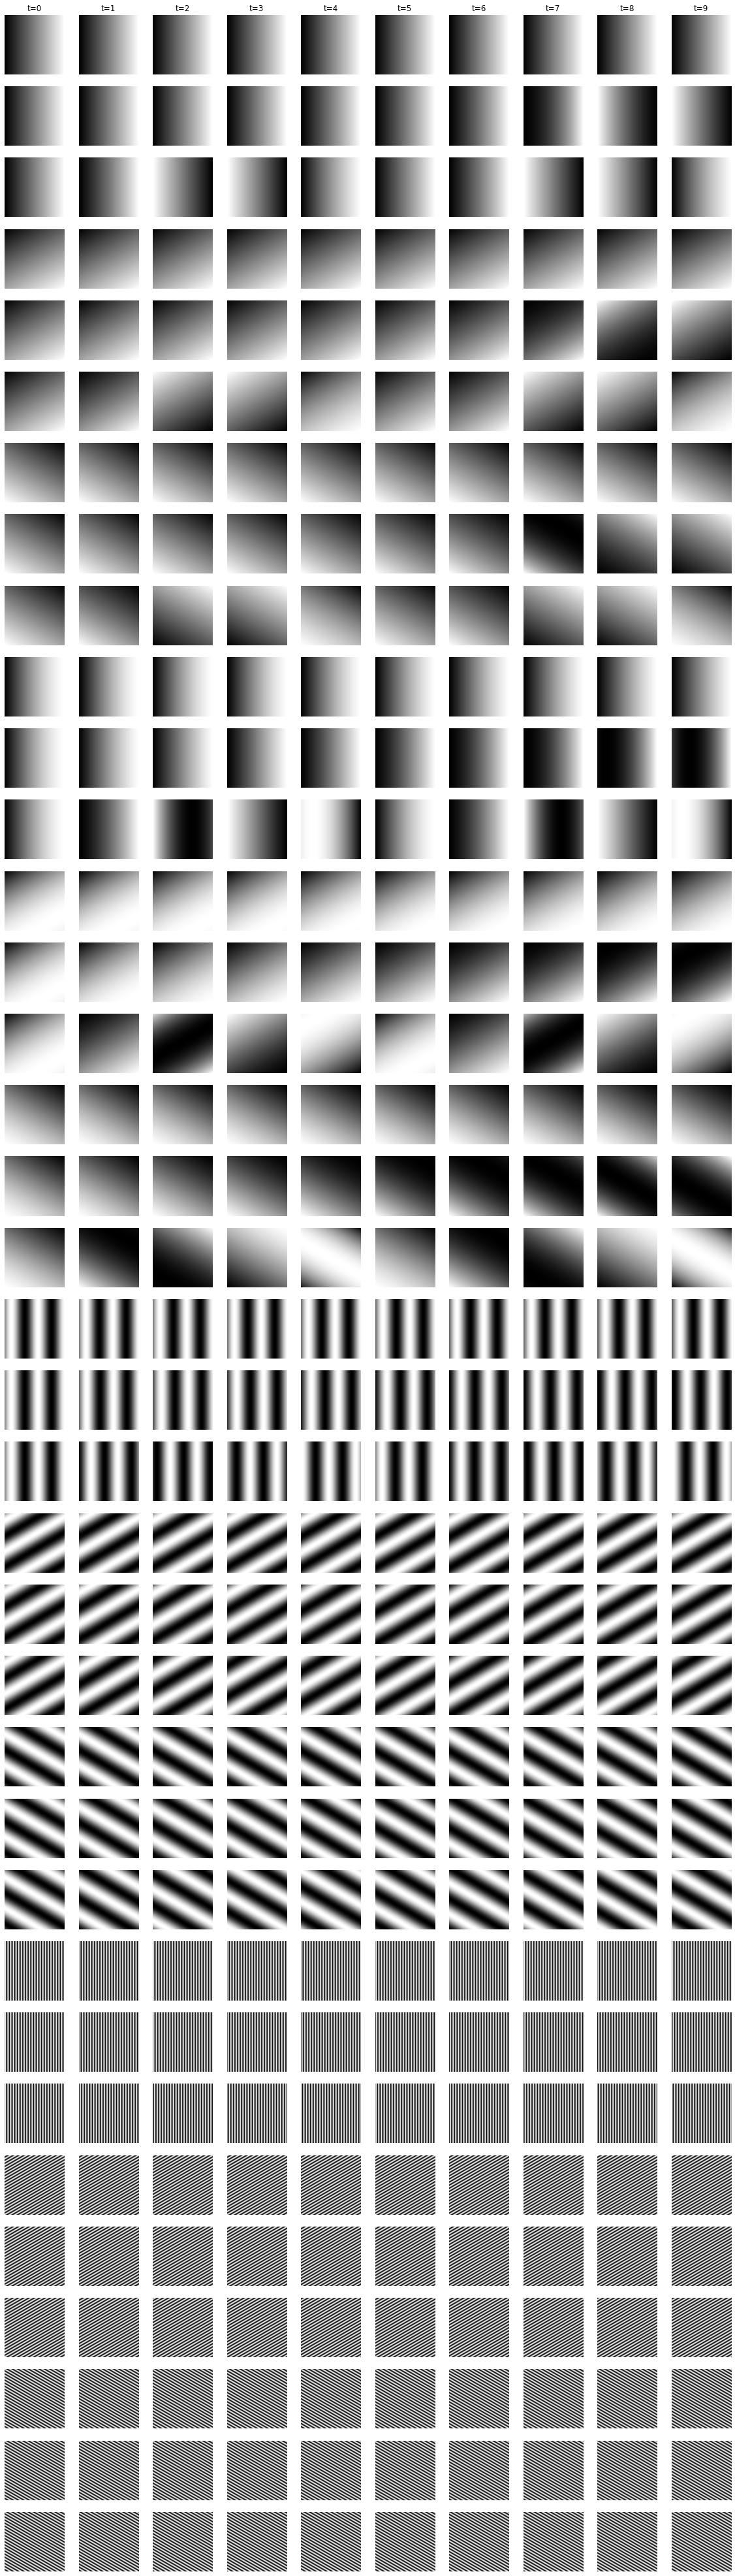

In [50]:
nrow=36
seq_size=[10,224,224]
stim_seqs = stim_seqs.reshape(nrow,10*224*224).T
_=visualize_image_seq(stim_seqs, nrow, seq_size, rand=False)

In [51]:
# Images are column vectors
def visualize_image(X, n_row=5, n_col=5, rand=True, image_size=[32, 32], vmax=None):
    plt.figure(figsize=(n_col,n_row))
    for idx in range(n_row * n_col):
        if rand:
            image_id = np.random.randint(0, X.shape[1])
        else:
            image_id = idx

        image = X[:, image_id].reshape(image_size)

        plt.subplot(n_row, n_col, idx + 1)
        if vmax is not None:
            plt.imshow(image, cmap='gray', vmin=0, vmax=vmax)
        else:
            plt.imshow(image, cmap='gray')
        plt.axis('off')

def visualize_image_seq(image_seqs, nrow, seq_size, rand=False):
    seq_len, width, height = seq_size
    assert seq_len*width*height==image_seqs.shape[0]
    
    fig,ax = plt.subplots(nrow,seq_len, figsize=(seq_len*2,2*nrow))
    
    for idx in range(nrow):
        if rand:
            image_id = np.random.randint(0, image_seqs.shape[1])
        else:
            image_id = idx

        image_seq = image_seqs[:, image_id].reshape(seq_size)
        for i_seq in range(seq_len):
            cax = ax[idx,i_seq]
            _=cax.imshow(image_seq[i_seq,...], cmap='gray')
            _=cax.axis('off')
            if idx==0:
                _=cax.set_title('t='+str(i_seq))
        
    return fig,ax
        
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6, labelsize=12)
    ax.yaxis.set_tick_params(size=6, labelsize=12)

# Part 1: ImageNet PCA

### Load dataset

It's rather easy to create imagenet crops, if you have imagenet already downloaded. I've provided a small dataset hosted on Google Drive that contains around 100,000 grayscale image crops.

!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1mF46SUDKzG0LkWkNGV1fP2hTEgW5WbF_',
                                    dest_path='./imagenet_32x32_crops.pt',
                                    unzip=False, overwrite = True, showsize=True)

In [19]:
# imagenet = torch.load('imagenet_32x32_crops.pt')
# X = imagenet.view([imagenet.shape[0], 3, -1]).mean(1).T.numpy()

In [20]:
import sys, os
from pathlib import Path
import joblib

In [21]:
def get_fpathlist(vid_root, subjdir, ds_rate=1):
    # read the image file names into fpathlist
    # subjdir = ['008MS'] #@@@

    # vid_root = r"/N/project/infant_image_statistics/03_JPG_AllMasters/"
    
    fpathlist = sorted(list(Path(os.path.join(vid_root, subjdir)).iterdir()), 
                       key=lambda x: x.name)
    fpathlist = [str(fpath) for fpath in fpathlist if fpath.suffix=='.jpg']
    fpathlist = fpathlist[::ds_rate]
    return fpathlist #TemporalNeighborhoodDataset(fpathlist, transform=get_transform(image_size))


In [122]:
import skimage
def center_crop(img, crop_size):
    # crop_size: int divisible by 
    # img size: divisible by 2
    if len(img.shape)==2:
        img = img[:,:,np.newaxis]#np.expand_dim(img,2)
    h,w,c = img.shape
    csh = crop_size//2
    hh, wh = h//2, w//2
    
    i_st = hh-csh
    i_end = hh+csh
    j_st = wh-csh
    j_end = wh+csh
    
    return img[i_st:i_end, j_st:j_end,:]

from skimage.transform import rescale
from skimage.util import img_as_ubyte
from skimage.color import rgb2gray

def get_transform(image_size, crop_size):

    # transform = tr.Compose([
    #     tr.Resize(image_size),
    #     tr.CenterCrop(image_size),
    #     tr.ConvertImageDtype(torch.float32),
    #     tr.Normalize(mean,std)
    # ])
    def xtransform(img): 
        
        if len(img.shape)==2:
            img = img[:,:,np.newaxis]#np.expand_dim(img,2)
        h,w, c = img.shape
        
        img_res = rgb2gray(cc)
        scale_f = image_size/min(h,w)
        img_res = rescale(img_res, scale_f, anti_aliasing=True)
        img_res = img_as_ubyte(img_res)
        img_res = center_crop(img_res, crop_size)
        
        return img_res
        
    return xtransform

from skimage.io import imread, imsave

def _proc_image(fpath, transform, outdir):

    # load
    img = imread(fpath)
    if img is None:
        warnings.warn('Image file at '+fpath+' could not be read!')
        return
    # transform (Reize)
    if transform is not None:
        img = transform(img)
    fname = Path(fpath).name#fpath.split('\')[-1]
    print('fname:',fname)
    save_path = outdir+fname
    print(save_path)
    imsave(save_path, img)
#     return img

In [59]:
jpg_root = 'D:/tmp_working_dir/homeview/'
subjdir = '004AB'
ds_rate = 1#5
fpathlist = get_fpathlist(jpg_root, subjdir, ds_rate=ds_rate)
print(len(fpathlist))

  0%|                                                                          | 14/12803 [32:50<500:02:42, 140.76s/it]


64015


In [23]:
import multiprocessing
num_workers = multiprocessing.cpu_count()
print("Number of CPU cores available:", num_workers)

Number of CPU cores available: 4


In [60]:
image_size = 224#32
crop_size=32
transform = get_transform(image_size, crop_size)
outdir = 'D:/tmp_working_dir/homeview/small_hw/g0/'

In [70]:
fp = fpathlist[0]
img = imread(fp)

# print(fp)
_proc_image(fp, transform, outdir)

C:\Users\Saber\AppData\Local\Temp/ipykernel_14116/1578811582.py:61: UserWarning: D:/tmp_working_dir/homeview/small_hw/g0/004AB_000040.jpg is a low contrast image
  imsave(save_path, img)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


fname: 004AB_000040.jpg
D:/tmp_working_dir/homeview/small_hw/g0/004AB_000040.jpg


In [152]:
inp = joblib.Parallel(n_jobs=num_workers-1, verbose=1)(
        joblib.delayed(_proc_image)(item, transform, outdir) 
        for item in tqdm(fpathlist))

100%|████████████████████████████████████████████████████████████████████████████| 64015/64015 [20:48<00:00, 51.27it/s]
[Parallel(n_jobs=3)]: Done 64015 out of 64015 | elapsed: 20.8min finished


In [168]:
new_fpathlist = get_fpathlist('D:/tmp_working_dir/homeview/small_hw/', 'g0', ds_rate=1)
X = joblib.Parallel(n_jobs=num_workers-1, verbose=1)(
        joblib.delayed(imread)(item) 
        for item in tqdm(new_fpathlist[:20000]))


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s][Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.

  1%|▊                                                                            | 204/20000 [00:02<02:01, 162.37it/s][Parallel(n_jobs=3)]: Done 140 tasks      | elapsed:    2.6s

 25%|███████████████████                                                         | 5004/20000 [00:14<00:34, 437.93it/s][Parallel(n_jobs=3)]: Done 4876 tasks      | elapsed:   14.0s

 61%|█████████████████████████████████████████████▊                             | 12204/20000 [00:30<00:17, 437.38it/s]


 65%|████████████████████████████████████████████████▋                          | 12972/20000 [00:31<00:16, 433.33it/s][Parallel(n_jobs=3)]: Done 12876 tasks      | elapsed:   32.0s

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:46<00:00, 430.10it/s]
[Parallel(n_jobs=3)]: Done 20000 out of 20000 | elapsed:   46.8s finished


In [154]:
X = np.asarray(X)
X = X.reshape(X.shape[0],-1)
print(X.shape)

(21339, 1024)


In [155]:
X=X.T

### Visualization

(1024, 21339)
0
255


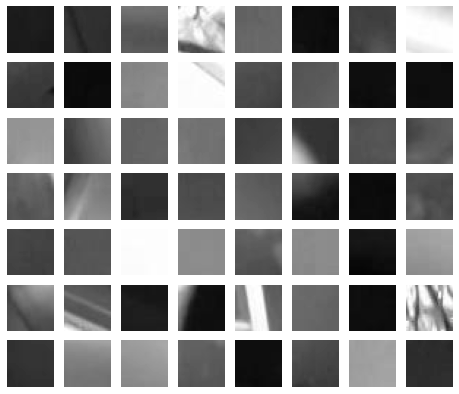

In [157]:
print(X.shape)
print(X.min())
print(X.max())
visualize_image(X,7,8, rand=True, vmax=255)
# plt.savefig("figures/imgs.pdf")

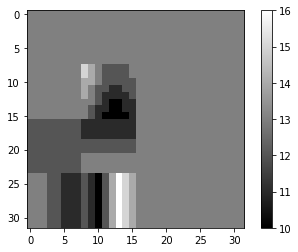

In [140]:
fp = new_fpathlist[0]
img = imread(fp)
plt.imshow(img, cmap='gray')#, vmin=0,vmax=255)
plt.colorbar()

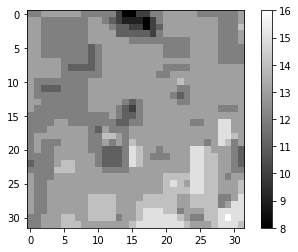

In [141]:
fp = fpathlist[0]
img = imread(fp)
img_res = rgb2gray(img)
scale_f = image_size/min(h,w)
img_res = rescale(img_res, scale_f, anti_aliasing=True)
img_res = img_as_ubyte(img_res)
img_res = center_crop(img_res, crop_size)

plt.imshow(img_res, cmap='gray')#, vmin=0,vmax=255)
plt.colorbar()

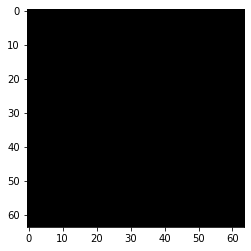

In [119]:
fp = fpathlist[0]
img = imread(fp)
scale_f = 1./2
crop_size = 32
tmp_crop_size = int(crop_size/scale_f)
img_res = rgb2gray(img)
img_res = center_crop(img_res, tmp_crop_size)
# scale_f = scale_f#5image_size/min(h,w)
# img_res = rescale(img_res, scale_f, anti_aliasing=True)
# img_res = img_as_ubyte(img_res)

plt.imshow(img_res, cmap='gray', vmin=0,vmax=255)

In [108]:
img_res.shape

(32, 32, 1)

# PCA Analysis

In [158]:
# Zero center
row_mean = X.mean(axis=1)
X_zero = X - row_mean.reshape([-1, 1])

In [159]:
# PCA
pca = decomposition.PCA()
pca.fit(X_zero.T)
pca_basis = pca.components_
pca_basis.shape

(1024, 1024)

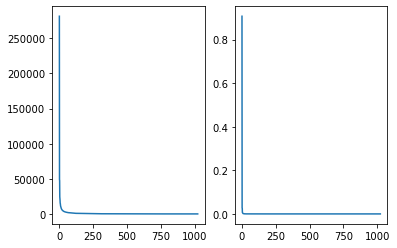

In [160]:
# Plot eigenval
plt.subplot(1, 2, 1)
plt.plot(pca.singular_values_)

plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_)
plt.show()

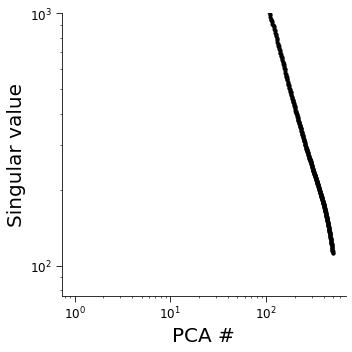

In [161]:
plt.figure(figsize=(5,5))
plt.plot(pca.singular_values_[:int(500)],'k.-')
ax=plt.gca()
simpleaxis(ax)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(top=1000)
# plt.xlim(1,100)
plt.xlabel("PCA #",fontsize=20)
plt.ylabel("Singular value",fontsize=20)
plt.tight_layout()
# plt.savefig("figures/PCA_spectrum.svg")

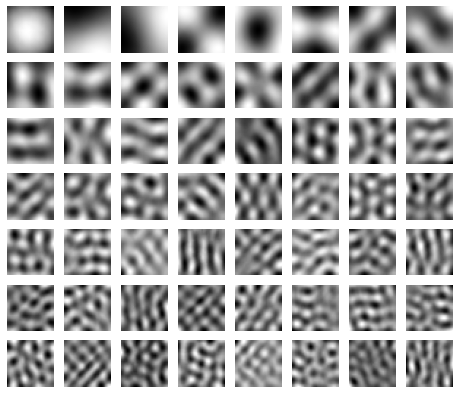

In [162]:
# PCA Basis
visualize_image(pca_basis.T, n_row=7, n_col=8, rand=False)
# plt.savefig("figures/pca_basis.pdf")

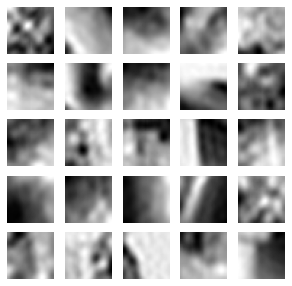

In [163]:
# PCA transformation
n_comp = 50
comp = pca_basis[:n_comp, :]

proj = comp @ X_zero
recon = comp.T @ proj
recon_mean = recon + row_mean.reshape([-1, 1])

visualize_image(recon_mean)

In [164]:
# PCA loss
loss_func = nn.MSELoss()
loss_func(torch.from_numpy(X_zero.T.astype(np.float32)), \
          torch.from_numpy(recon.T.astype(np.float32)))

tensor(9.9410)

## Spatiotemporal PCA

In [170]:
X = np.asarray(X)
n_fr, w, h = X.shape

In [172]:
seq_len = 2
X = X.reshape(int(n_fr/seq_len), -1).T
X.shape

(2048, 10000)

In [173]:
# Zero center
row_mean = X.mean(axis=1)
X_zero = X - row_mean.reshape([-1, 1])
# PCA
pca = decomposition.PCA()
pca.fit(X_zero.T)
pca_basis = pca.components_
pca_basis.shape

(2048, 2048)

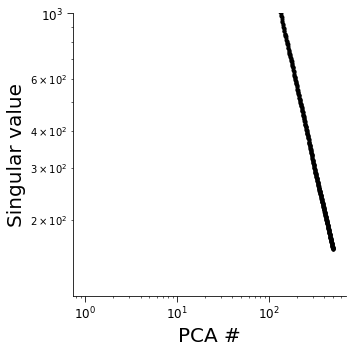

In [175]:
plt.figure(figsize=(5,5))
plt.plot(pca.singular_values_[:int(500)],'k.-')
ax=plt.gca()
simpleaxis(ax)
ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(top=1000)
# plt.xlim(1,100)
plt.xlabel("PCA #",fontsize=20)
plt.ylabel("Singular value",fontsize=20)
plt.tight_layout()
# plt.savefig("figures/PCA_spectrum.svg")

In [179]:
image_size

224

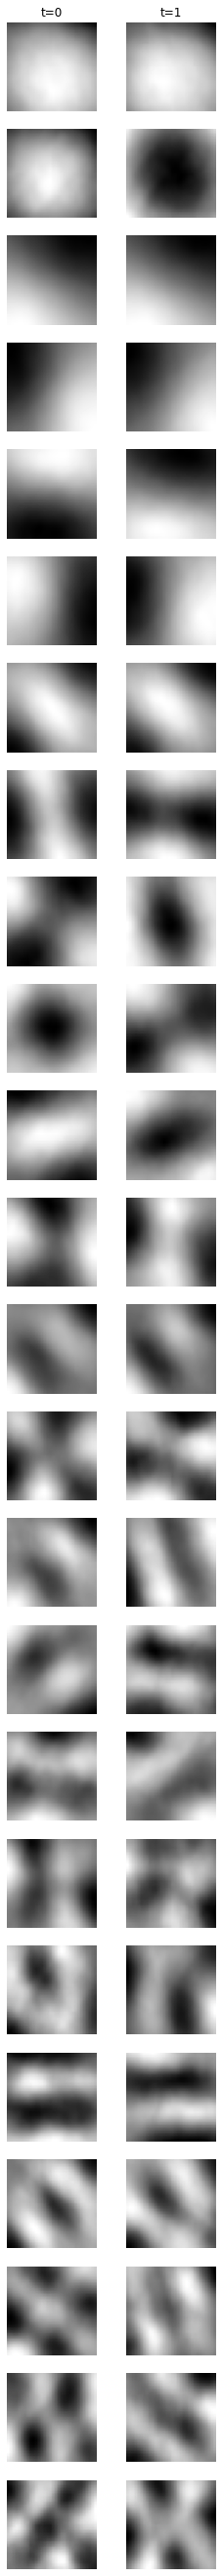

In [189]:
# PCA Basis
seq_size = (seq_len, crop_size,crop_size)
_ = visualize_image_seq(pca_basis.T, 24, seq_size, rand=False)

# visualize_image(pca_basis.T, n_row=7, n_col=8, rand=False)

# PCA with Neural Network

### Helper class and function

In [ ]:
input_X = torch.from_numpy(X_zero.T.astype(np.float32)).cuda()

import functools as ft
class LinearNetwork:
  # init with a list of weight matrix
  def __init__(self, pca_basis, init_scale, *weight_shape):
    self.weight = [(torch.rand(mtx_shape)*init_scale-init_scale/2)\
                   .clone().detach().cuda().requires_grad_(True)\
                   for mtx_shape in weight_shape]
    self.symmetric=False
    self.pca_basis = torch.from_numpy(pca_basis.astype(np.float32)).cuda()

  def transform_mtx(self):
    # pca transformation encoded by the network
    w = ft.reduce(lambda a, b: b.mm(a), self.weight)
    return w.t().mm(w) if self.symmetric else w

  def forward(self, input):
    # forward transformation on data
    transform = self.transform_mtx()
    return input.mm(transform)
    
  def decompose(self):
    # alignment with PCA basis
    with torch.no_grad():
      transform = self.transform_mtx()
      if not self.symmetric: 
        transform = transform.mm(transform.t())

      diag = self.pca_basis.mm(transform).mm(self.pca_basis.T)      

      return np.diag(diag.detach().cpu().numpy())

  # useful visualization
  def plot_decomposition(self, n_item):
    diag = self.decompose()[:n_item]
    plt.plot(diag)
    plt.show()

  def show_reconstruction(self, input):
    with torch.no_grad():
      output = self.forward(input).detach().cpu().numpy().T
      visualize_image(output)

    

In [ ]:
def pca_learning(input, network, n_epoch=1000, batch_size=100, n_item=50, sgd=True, lr=0.01, return_weight_every=False):
  # Gradient descent training
  optimizer = optim.SGD(network.weight, lr=lr)  
  if not sgd:
    optimizer = optim.Adam(network.weight)

  loss_func = nn.MSELoss()
  loss_val  = np.zeros(n_epoch)
  diag_val  = np.zeros([n_epoch, n_item])

  weights=[]
  for epoch in tqdm(range(n_epoch)): 
    if return_weight_every is not None:
        if epoch % return_weight_every ==0:
            weights.append(network.weight[0].detach().cpu())
    # diagonalization of network transformation with PCA basis
    diag = network.decompose()
    diag_val[epoch, :] = diag[0:n_item]
    
    # SGD training
    shuffle_idx = np.random.permutation(len(input))
    batches = torch.split(input[shuffle_idx], batch_size)
    
    for batch in batches:
        optimizer.zero_grad()
        output = network.forward(batch)
    
        loss = loss_func(batch, output + torch.randn_like(output)*.1)
        loss.backward()        
        optimizer.step()

        
    # evalulation after each epoch
    with torch.no_grad():
        output = network.forward(input)
        loss_val[epoch] = loss_func(input, output)

  if return_weight_every is not None:
    return (loss_val, diag_val, weights)
  return (loss_val, diag_val)

In [ ]:
# helper function for plotting the loss function
def plot_loss(loss_val):
  fig = plt.figure(figsize=(10, 3), dpi=100)
  plt.subplot(1, 2, 1)
  plt.plot(loss_val)

  n_epoch = loss_val.size
  index = int(n_epoch * 0.75)
  plt.subplot(1, 2, 2)
  plt.plot(range(n_epoch)[index:], loss_val[index:])

In [ ]:
# helper function for temporal dynamics
def plot_temporal(diag_val, t_step, n_plot=20,cmap="Blues"):
  colors = sns.color_palette(cmap,n_colors=n_plot)
  for idx in range(n_plot):
    plt.plot(range(t_step), diag_val[:t_step, idx], c=colors[-(idx+1)])
  

In [ ]:
def sinusoid(freq,phase=0, contrast=1):
    arr= torch.ones(1,32,32)
    arr*=torch.linspace(0,3.14159,32)
    arr = contrast*.5*torch.sin(freq*arr+phase)+.5
    return arr.view(-1,32**2).cuda()

def get_sensitivity(net, low=1,high=10,n=20, weight=None, n_phases=64, plot=True, log_x=False,contrast=1):
    fs = [torch.autograd.Variable(f, requires_grad=True) for f in torch.linspace(low,high,n)]
    if weight is None:
        w = ft.reduce(lambda a, b: b.mm(a), net.weight)
    else:
        w = weight

    sensitivity=[]
    for f in fs:
        all_sens=[]
        for phase in np.linspace(0,np.pi,n_phases):
            func = lambda l: sinusoid(l,phase,contrast).mm(w.t())
            all_sens.append(torch.autograd.functional.jacobian(func, f, vectorize=True).pow(2).sum())
        sensitivity.append(np.mean(all_sens))
        
    if plot:
        fig = plt.figure(figsize=(8, 4), dpi=300)
        plt.subplot(1, 2, 1)
        plt.plot(np.linspace(low,high,n)/64*100,sensitivity)
        plt.ylabel("Fisher Information")
        plt.xlabel("Spatial frequency (cycles/ 100 pixels)")
        if log_x:
            plt.gca().set_xscale('log')
        plt.subplot(1,2,2)

        plt.plot(np.linspace(low,high,n)/64*100,np.power( sensitivity,-.5))
        plt.xlabel("Cycles/ 100 pixels")
        plt.ylabel(r"Threshold $J(\theta)^{-\frac{1}{2}}$")
        if log_x:
            plt.gca().set_xscale('log')
    else:
        return sensitivity


### One-matrix reconstruction

$$\hat{X}=W_1X$$
$$\ell(W)=\sum_j(x_j-\hat{x_j})^2$$

#### Before training

In [ ]:
n_comp = 50
input_size = 32 * 32

one_layer = LinearNetwork(pca_basis, 0.01, (input_size, input_size))
one_layer.symmetric=True

In [ ]:
# Before training, diagonalization with PCA basis
one_layer.plot_decomposition(n_item=50)
one_layer.show_reconstruction(input_X)

#### Training

In [ ]:
# Training
loss_val, diag_val, weights = pca_learning(input_X, one_layer, n_epoch=1000, batch_size=16384, n_item=50, sgd=True,
                                 lr=1, return_weight_every=1)

In [ ]:
def plot_temporal(diag_val, t_step, n_plot=20,cmap="Blues"):
  colors = sns.color_palette(cmap,n_colors=n_plot)
  for idx in range(n_plot):
    p=plt.plot(range(t_step), diag_val[:t_step, idx], c=colors[-(idx+1)])
  sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap+'_r'), norm=plt.Normalize(0,n_plot))
  cb=plt.colorbar(sm)
  cb.set_label(label="PCA #", fontsize=20)

  

plot_temporal(diag_val, t_step=500, n_plot=50, cmap='Spectral')
plt.xlabel("Learning steps", fontsize=20)
plt.ylabel("Proportion learned", fontsize=20)
# plt.savefig("figures/pca_learning_1layer.svg")

In [ ]:
def learning_3d(diag_val, low=1,high=50, n_epoch=1000, n_every=100):
    n=n_epoch//n_every
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111, projection='3d')
    m=1
    x = np.linspace(low,high)/64*100
    y = np.arange(0,n_epoch, n_every//m)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros((len(y),len(x)))
    
    for i in range(n):
        
        
        Z[m*i] = diag_val[i*n_every]
    ax.plot_surface(X, Y, Z, rstride=50, cstride=2, color='w', 
                        shade=False, lw=.5, edgecolors='k', zorder=10)

    ax.set_zlim(0, 1)
#     ax.set_xlim(-51, 51)
    ax.set_zlabel("Percentage learned",fontsize=15,labelpad=10)
    ax.set_xlabel("PCA basis",fontsize=15,labelpad=10)
    ax.set_ylabel("Epoch", fontsize=15)
    plt.tight_layout()
#     ax.view_init(30,-70)
learning_3d(diag_val, n_every=1)

#### Fisher of each basis
This is $\sum_i\frac{\partial Wx}{\partial v_i}^2x$. In the axis-aligned case it's $\sigma_i(t)$.

#### Sinusoidal gratings

In [ ]:
def plot_webers(list_of_weights, low=1,high=10,n_x=20, n_epoch=1000, n_every=50, n_phases=1, which=None,
               cmap='cividis_r', contrast=1):
    n=len(list_of_weights)
#     fig = plt.figure(figsize=(6,5), dpi=100)
    colors = sns.color_palette(cmap,n_colors=n, )

    m=10
    x = np.linspace(low,high,n_x)/64*100
    if which is None:
        which = range(0,n,n_every)
    for i in which:
        sensitivity = get_sensitivity(None, weight=list_of_weights[i].cuda(), n_phases=n_phases, plot=False, 
                                      n=n_x, contrast=contrast)

        plt.plot(x,np.power( sensitivity,-.5), c=colors[i])
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=plt.Normalize(0,n_epoch))
    cb=plt.colorbar(sm)
    cb.set_label(label="Learning steps", fontsize=15)
    plt.xlabel("Spatial frequency\n (cycles/100 pix.)", fontsize=20)
    plt.ylabel(r"Threshold ($D(\theta)^{-\frac{1}{2}}$)", fontsize=20)
    
plot_webers(weights[:], which=list(range(0,1000,50)) ,n_phases=16, contrast=1)
plt.tight_layout()
# plt.savefig("figures/webers_1layer.svg")

In [ ]:
def time_to_thresh(weights, sigma, delta=0.01):
    thresholds =[]
    thresh=1
    jnd=10
    old_jnd=10
    for w in tqdm(weights):
        included=False
        while not included:
            sensitivity = get_sensitivity(None, low=thresh,high=thresh+delta,n=1, weight=w.cuda(), 
                                          n_phases=64, plot=False, log_x=False)
            jnd = np.power(sensitivity,-.5)[0]
            if jnd > sigma and old_jnd < sigma:
                thresholds.append(thresh)
                included=True
                old_jnd=0
            elif thresh>20:
                thresh=0
                thresholds.append(thresh)
                included=True
            else: 
                thresh+=delta
                old_jnd=jnd
            
    return thresholds
thresholds=time_to_thresh(weights[2:],.1, .05)

In [ ]:
plt.figure(figsize=(5,4))

x=np.arange(2,1000)/64*100
y=thresholds
plt.plot(x[10:],np.power(thresholds[10:],2),'.',c='k')
# plt.gca().set_yscale('log')
# plt.gca().set_xscale('log')
plt.ylabel("Network acuity\n(max freq. w/ thresh. <.1)",fontsize=20)
plt.xlabel("Learning steps",fontsize=20)
plt.tight_layout()
# plt.savefig("figures/linear_learning_linscale.svg")

### Two-Layer

$$\hat{X}=W_2W_1X$$

In [ ]:
n_comp = 50
input_size = 32 * 32

deep_net = LinearNetwork(pca_basis, 0.01, (input_size, input_size), (input_size, input_size))

In [ ]:
# Training
n_epoch =1000
loss_val, diag_val,weights2 = pca_learning(input_X, deep_net, n_epoch=n_epoch, batch_size=4096, n_item=50, sgd=True, lr=1, 
                                 return_weight_every=10)

In [ ]:
plot_temporal(diag_val, t_step=1000, n_plot=50, cmap='Spectral')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Proportion learned", fontsize=15)
# plt.savefig("pca_learning_2layer.pdf")

In [ ]:
def plot_webers(list_of_weights, low=1,high=10,n_x=20, n_epoch=1000, n_every=50, n_phases=1,
               cmap='Blues_r',from_=0):
    n=len(list_of_weights)
#     fig = plt.figure(figsize=(6,5), dpi=100)
    colors = sns.color_palette(cmap,n_colors=n)

    m=10
    x = np.linspace(low,high,n_x)/64*100
    
    for i in range(from_,n,n_every):
        sensitivity = get_sensitivity(None, weight=list_of_weights[i].cuda(), n_phases=n_phases, plot=False, n=n_x)

        plt.plot(x,np.power( sensitivity,-.5), c=colors[i])
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cmap), norm=plt.Normalize(0,n_epoch))
    cb=plt.colorbar(sm)
    cb.set_label(label="Epoch", fontsize=15)
    plt.xlabel("Cycles/ 100 pixels", fontsize=15)
    plt.ylabel(r"Threshold $J(\theta)^{-\frac{1}{2}}$", fontsize=15)
plot_webers(weights2, from_=3, n_every=10,n_phases=27)
# plt.savefig("webers_2layer.pdf")

In [ ]:
plot_temporal(diag_val, t_step=200, n_plot=15)

### Three-Layer

$$\hat{X}=W_3W_2W_1X$$

In [ ]:
n_comp = 50
input_size = 32 * 32

three_net = LinearNetwork(pca_basis, 0.02, (input_size, input_size),(input_size, input_size), (input_size, input_size))

In [ ]:
# Training
n_epoch = 1000
loss_val, diag_val, weights3 = pca_learning(input_X, three_net, n_epoch=n_epoch, batch_size=4096, n_item=50, sgd=True, lr=1,
                                 return_weight_every=100)

In [ ]:
plot_temporal(diag_val, t_step=1000, n_plot=50, cmap='Spectral')
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Proportion learned", fontsize=15)
# plt.savefig("pca_learning_3layer.pdf")

In [ ]:
plot_webers(weights3[1:], n_every=100,n_phases=27)
# plt.savefig("webers_3layer.pdf")

In [ ]:
plot_temporal(diag_val, t_step=500, n_plot=15)
# plt.axis('off')
# plt.savefig("Evolution.pdf")

plt.show()

In [ ]:
get_sensitivity(three_net)